<a href="https://colab.research.google.com/github/MehrdadJalali-AI/GraphMOF-AI/blob/main/MOFGalaxyNet_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training GNN: 100%|██████████| 200/200 [00:00<00:00, 541.75it/s]



🔹 Insights for MOF-5: Without contextual information, specific behaviors or properties of a Material, in this case, Metal-Organic Frameworks (MOF-5, in particular), cannot be discerned from just two embedding vector values. These vectors are abstract representations learned by machine learning models trained on large amounts of data.

Embedding vectors such as the given ones are typically obtained from complex machine learning models that have been trained to capture high-dimensional relationships in the data. However, without information about the model that produced these values (such as the type and structure of the model, the data it was trained on, and the specific task it was trained for), we cannot make direct inferences about the characteristics or properties represented by the given values.

These numerical values in embedding space may capture some semantic properties of the material, but they do not directly correspond to physical properties like stability, gas adsorption, 

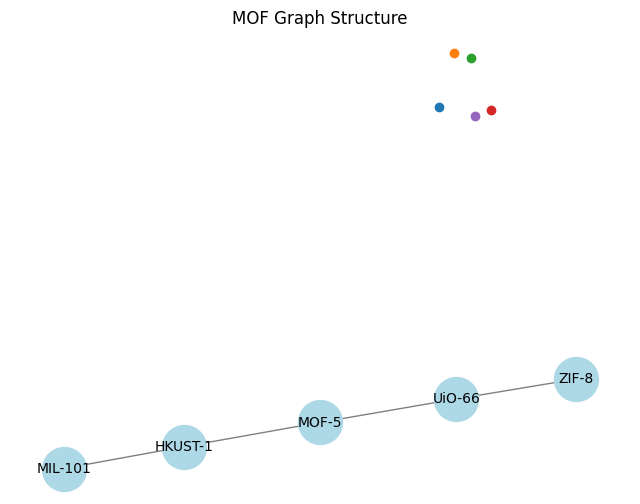

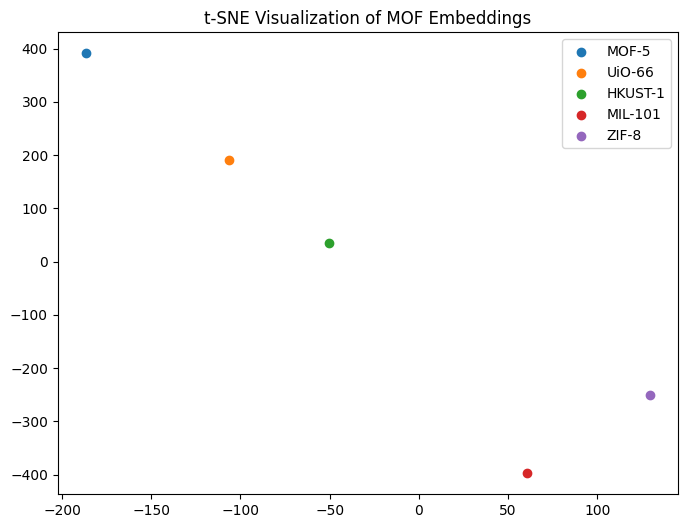

In [3]:
import torch
import networkx as nx
import openai
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE
from tqdm import tqdm

# OpenAI API Key (Replace with your key)
openai.api_key = ""
# Step 1: Define a Simple MOF Graph
def create_mof_graph():
    G = nx.Graph()

    # Add MOF Nodes
    mof_nodes = ["MOF-5", "UiO-66", "HKUST-1", "MIL-101", "ZIF-8"]
    for node in mof_nodes:
        G.add_node(node, adsorption=np.random.rand(), stability=np.random.rand())

    # Add Edges (Connectivity based on shared features)
    edges = [("MOF-5", "UiO-66"), ("MOF-5", "HKUST-1"), ("HKUST-1", "MIL-101"), ("UiO-66", "ZIF-8")]
    G.add_edges_from(edges)

    return G

# Step 2: Convert NetworkX Graph to PyTorch Geometric Format
def graph_to_pyg(G):
    node_mapping = {node: i for i, node in enumerate(G.nodes)}

    edge_index = torch.tensor(
        [[node_mapping[u], node_mapping[v]] for u, v in G.edges], dtype=torch.long
    ).t().contiguous()

    features = torch.tensor(
        [[G.nodes[node]["adsorption"], G.nodes[node]["stability"]] for node in G.nodes], dtype=torch.float
    )

    return Data(x=features, edge_index=edge_index)

# Step 3: Define a GNN Model for MOF Representation Learning
class MOFGraphGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MOFGraphGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Step 4: Train GNN on MOF Graph
def train_gnn(data):
    model = MOFGraphGNN(in_channels=2, hidden_channels=16, out_channels=2)  # Change output size to 2
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = torch.nn.MSELoss()

    for epoch in tqdm(range(200), desc="Training GNN"):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)  # Output embeddings
        loss = loss_fn(out, data.x)  # Ensure matching dimensions
        loss.backward()
        optimizer.step()

    return model, out  # Return trained model and embeddings


# Step 5: Extract Embeddings and Send to GPT-4 for Insights
def llm_mof_insights(embeddings, mof_names):
    insights = {}

    for i, mof in enumerate(mof_names):
        embedding_str = ", ".join([f"{v:.4f}" for v in embeddings[i].tolist()])

        prompt = f"""
        Given the embedding vector {embedding_str} for {mof},
        what insights can be inferred about its potential applications,
        stability, and gas adsorption properties? Provide a detailed response.
        """

        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}]
        )

        insights[mof] = response["choices"][0]["message"]["content"]

    return insights

from sklearn.manifold import TSNE

# Step 6: Visualize MOF Graph and t-SNE Embeddings
def visualize_graph(G, embeddings, mof_names):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))

    for i, node in enumerate(G.nodes):
        plt.scatter(embeddings[i, 0], embeddings[i, 1], label=node)

    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=1000, font_size=10)
    plt.title("MOF Graph Structure")
    plt.show()

    # ✅ Fix: Adjust perplexity dynamically (ensure it's less than n_samples)
    perplexity_value = min(len(mof_names) - 1, 2)  # Ensures perplexity < n_samples

    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    transformed = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for i, mof in enumerate(mof_names):
        plt.scatter(transformed[i, 0], transformed[i, 1], label=mof)

    plt.legend()
    plt.title("t-SNE Visualization of MOF Embeddings")
    plt.show()


# Execute Workflow
G = create_mof_graph()
data = graph_to_pyg(G)
model, embeddings = train_gnn(data)
insights = llm_mof_insights(embeddings.detach().numpy(), list(G.nodes))

# Display LLM Insights
for mof, insight in insights.items():
    print(f"\n🔹 Insights for {mof}: {insight}")

# Visualize Graph & Embeddings
visualize_graph(G, embeddings.detach().numpy(), list(G.nodes))


In [1]:
pip install openai==0.28

In [2]:
!pip install torch-geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=545106 sha256=09cdda22b24c8c028dd2fb766741be9658bb29e21178af26a7f48436f801e3df
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1122943 sha256=1a5431d7be7a1f1736596cc00d62c5a5db7257e95d399d40afcd8ddaf68e0654
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c59606383